## Log parser

In [39]:
import os
import re
from collections import defaultdict

In [40]:
log_filename = "sendtransfer_cd_log_files/VN_0.15_0.05.log"
dim = 200, 200
initial_val = 0
#log_filename = "covid_store.log"
#dim = 64, 100
#initial_val = None
patt_out_line = ".*Y / (?P<time>[0-9]{2}:[0-9]{2}:[0-9]{2}:[0-9]{3})(?::0)? / [a-zA-Z0-9]+\((?P<x>[0-9]+),(?P<y>[0-9]+)\)\([0-9]+\) / out / +(?P<state>[0-9.-]+) (?:/|para) [a-zA-Z0-9]+\([0-9]+\)"

In [75]:
ID_SUSCEPTIBLE = 0
ID_INFECTED = 1
ID_SICK = 8
ID_RECOVERED = 16
ID_DEAD = -1
ID_WALL = -10

COLOR_SUSCEPTIBLE = "0.5"  # gray 50%
COLOR_INFECTED = "blue"
COLOR_SICK = "red"
COLOR_RECOVERED = "green"
COLOR_DEAD = "black"

In [76]:
def time_str_to_ts(time_str):
  patt_time = "([0-9]{2}):([0-9]{2}):([0-9]{2}):([0-9]{3})"
  match = re.match(patt_time, time_str)
  if not match:
    raise RuntimeError("Error converting simulation time")
  tu = list(map(int, match.groups()))
  return tu[3] + tu[2]*1000 + tu[1]*60000 + tu[0]*3600000

def dict_to_states_row(states_dict):
  row = []
  row.append(states_dict[ID_SUSCEPTIBLE] if ID_SUSCEPTIBLE in states_dict else 0)
    
  infected_count = 0
  for state in range(ID_INFECTED, ID_SICK):
    if state in states_dict:
      infected_count += states_dict[state]
  row.append(infected_count)

  sick_count = 0
  for state in range(ID_SICK, ID_RECOVERED):
    if state in states_dict:
      sick_count += states_dict[state]
  row.append(sick_count)
    
  for state in [ID_RECOVERED, ID_DEAD, ID_WALL]:
    row.append(states_dict[state] if state in states_dict else 0)
  return row


In [77]:
state_count = defaultdict(int)
df_rows = []
curr_states = [[initial_val] * dim[1] for _ in range(dim[0])]
if initial_val is not None:
    state_count[initial_val] = dim[0]*dim[1]

In [78]:
log_state_changes_to_file = False

if log_state_changes_to_file:
  csv_file = open("state_changing.csv", "w")
  csv_file.write(",".join(("time", "x", "y", "previous_state", "current_state")) + "\n")
curr_time = None

with open(log_filename, "r") as log_file:
  for line in log_file:
    line = line.strip()
    match = re.match(patt_out_line, line)
    if not match:
      if line.startswith("Mensaje Y"):
        print(line)
      continue
    if curr_time is None:
      curr_time = match.group("time")
    elif curr_time != match.group("time"):
      #print("Changed to " + match.group("time"))

      row = [time_str_to_ts(curr_time)] + dict_to_states_row(dict(state_count.items()))
      df_rows.append(row)

      curr_time = match.group("time")

    x = int(match.group("x"))
    y = int(match.group("y"))
    
    if not curr_states[x][y] is None:
      state_count[curr_states[x][y]] -= 1

    if log_state_changes_to_file:
      csv_file.write((",".join((match.group("time"), match.group("x"), match.group("y"), str(curr_states[x][y]), str(int(float(match.group("state"))))))))
      csv_file.write("\n")
    #print("Time: %s, cell (%s, %s) changing from %d to %s" % (match.group("time"), match.group("x"), match.group("y"), curr_states[x][y], match.group("state")))
    curr_states[x][y] = int(float(match.group("state")))
    state_count[int(float(match.group("state")))] += 1

if log_state_changes_to_file:
  csv_file.close()

In [79]:
df_rows[:8]

[[1, 39997, 3, 0, 0, 0, 0],
 [2, 39994, 6, 0, 0, 0, 0],
 [3, 39993, 7, 0, 0, 0, 0],
 [4, 39992, 8, 0, 0, 0, 0],
 [7, 39989, 8, 3, 0, 0, 0],
 [8, 39987, 7, 6, 0, 0, 0],
 [9, 39986, 5, 9, 0, 0, 0],
 [10, 39980, 10, 9, 0, 1, 0]]

In [80]:
df_rows[-8:]

[[1692, 1081, 0, 2, 25702, 13215, 0],
 [1693, 1081, 0, 2, 25702, 13215, 0],
 [1694, 1081, 0, 2, 25702, 13215, 0],
 [1695, 1081, 0, 2, 25702, 13215, 0],
 [1696, 1081, 0, 1, 25702, 13216, 0],
 [1697, 1081, 0, 1, 25702, 13216, 0],
 [1698, 1081, 0, 1, 25702, 13216, 0],
 [1699, 1081, 0, 1, 25702, 13216, 0]]

## Dataframe creation and visualization

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [82]:
columns = ["time", "susceptible", "infected", "sick", "recovered", "dead", "walls"]
df = pd.DataFrame(df_rows, columns=columns)
df = df.set_index("time")
df.head()

,susceptible,infected,sick,recovered,dead,walls
time,,,,,,
1,39997,3,0,0,0,0
2,39994,6,0,0,0,0
3,39993,7,0,0,0,0
4,39992,8,0,0,0,0
7,39989,8,3,0,0,0


In [83]:
total_cells = sum(df.iloc[0,:])
population = total_cells - df.iloc[0,:]["walls"]
print("Total cells: %d, population: %d" % (total_cells, population)) 

Total cells: 40000, population: 40000


In [84]:
df_vis = df.copy()
df_vis = df_vis.drop(["walls"], axis=1)
df_vis = df_vis.divide(population)
df_vis.head()

,susceptible,infected,sick,recovered,dead
time,,,,,
1,0.999925,0.000075,0.000000,0.0,0.0
2,0.999850,0.000150,0.000000,0.0,0.0
3,0.999825,0.000175,0.000000,0.0,0.0
4,0.999800,0.000200,0.000000,0.0,0.0
7,0.999725,0.000200,0.000075,0.0,0.0


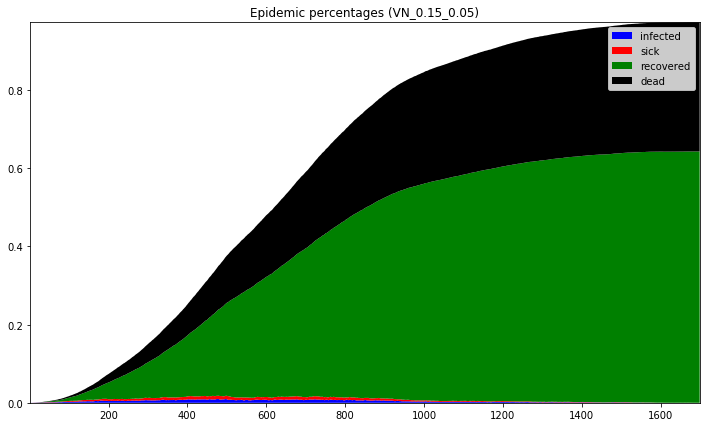

In [85]:
base_name = os.path.splitext(os.path.basename(log_filename))[0]

col_names = ["infected", "sick", "recovered", "dead"]
colors=[COLOR_INFECTED, COLOR_SICK, COLOR_RECOVERED, COLOR_DEAD]

x = list(df_vis.index)
y = np.vstack([df_vis[col] for col in col_names])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
plt.title('Epidemic percentages (%s)' % base_name)
#plt.show()
plt.savefig(base_name + "_area.png")

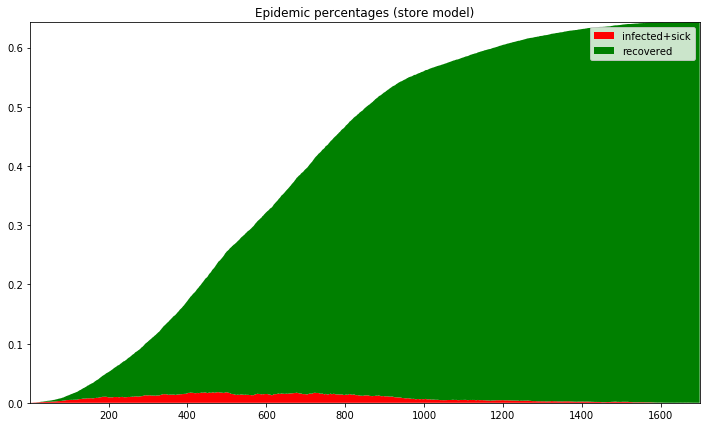

In [86]:
col_names = ["infected+sick", "recovered"]
colors = [COLOR_INFECTED, COLOR_RECOVERED]
x = list(df_vis.index)
y = np.vstack([df_vis["infected"]+df_vis["sick"], df_vis["recovered"]])

fig, ax = plt.subplots(figsize=(12,7))
ax.stackplot(x, y, labels=col_names, colors=colors)
plt.legend(loc='upper right')
plt.margins(0,0)
plt.title('Epidemic percentages (store model)')
plt.show()

#plt.stackplot(list(df_vis.index),  df_vis["infected"]+df_vis["sick"], df_vis["recovered"], labels=col_names)


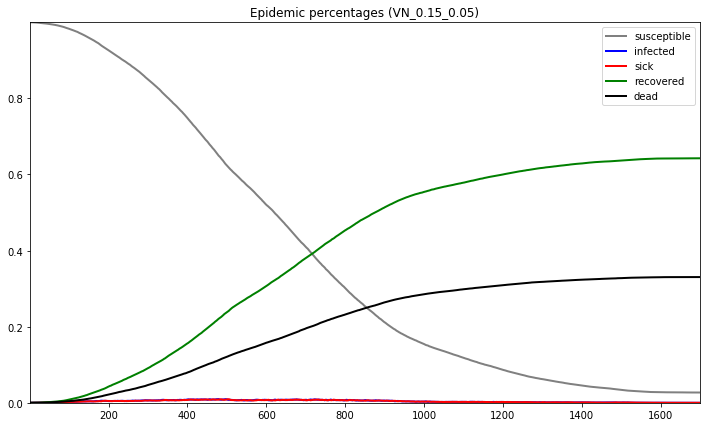

In [91]:
fig, ax = plt.subplots(figsize=(12,7))
linewidth = 2

x = list(df_vis.index)
ax.plot(x, df_vis["susceptible"], label="susceptible", color=COLOR_SUSCEPTIBLE, linewidth=linewidth)
ax.plot(x, df_vis["infected"], label="infected", color=COLOR_INFECTED, linewidth=linewidth)
ax.plot(x, df_vis["sick"], label="sick", color=COLOR_SICK, linewidth=linewidth)
ax.plot(x, df_vis["recovered"], label="recovered", color=COLOR_RECOVERED, linewidth=linewidth)
ax.plot(x, df_vis["dead"], label="dead", color=COLOR_DEAD, linewidth=linewidth)
plt.legend(loc='upper right')
plt.margins(0,0)
plt.title('Epidemic percentages (%s)' % base_name)
plt.savefig(base_name + "_lines.png")